In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from glimmer.model import train_neighbor_weights, set_seed
from glimmer.utils import spatial_smooth

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set path & parameters
seed = 42 
device = 'cuda:1'
save_fig = True
pt_size = 45
main_path = '/data/qiyu/spatialRegion/'
fig_path = main_path + 'figures/SVG/'
dir = main_path + 'data/slidetag/slidetag_mouse_embryonic_E14_brain'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans' 

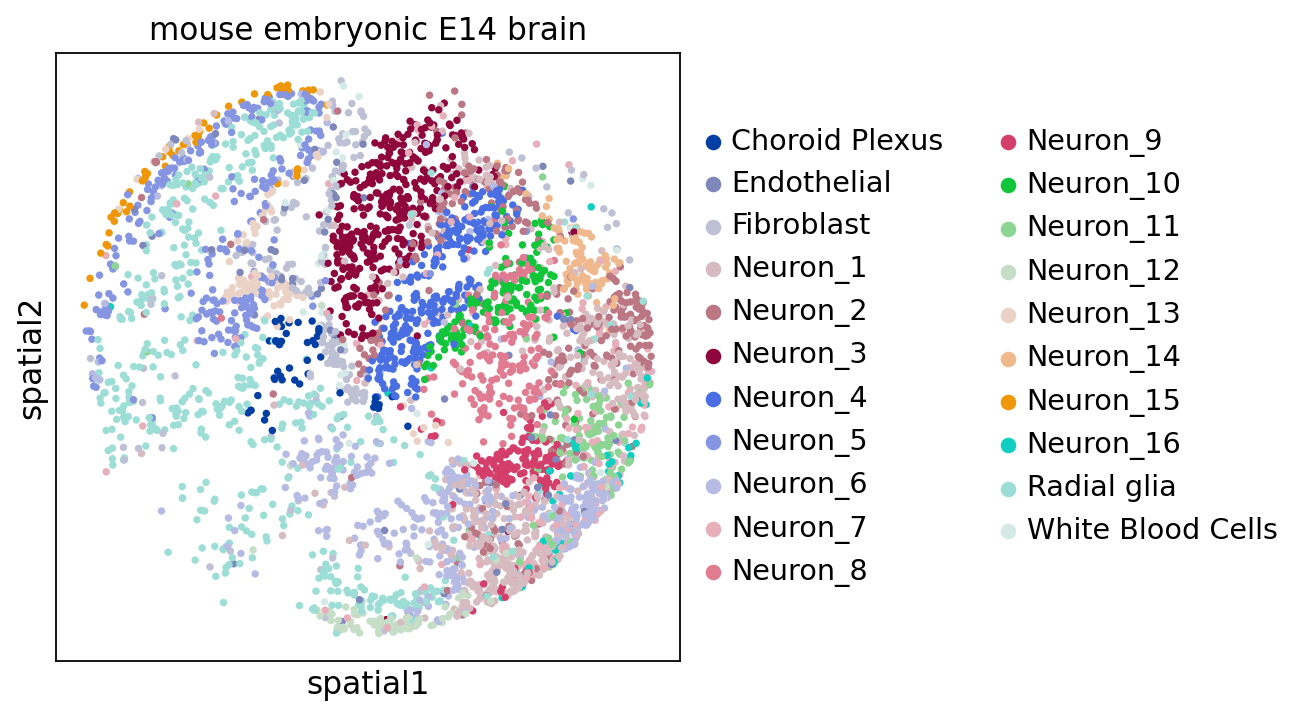

In [3]:
adata_path = os.path.join(dir, 'RNA_adata_circle.h5ad')

if os.path.exists(adata_path):  
    adata = sc.read_h5ad(adata_path)  
else:
    # Load data 
    adata = sc.read_h5ad(os.path.join(dir, 'RNA_adata.h5ad'))
    
    # Normalization and preprocessing
    sc.pp.normalize_total(adata, target_sum=1e4) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

    # Subset adata using circular selection
    spatial_coords = adata.obsm['spatial']
    center_x, center_y = 360, -2850
    radius = 1300
    distances = np.sqrt(
        (spatial_coords[:, 0] - center_x)**2 + 
        (spatial_coords[:, 1] - center_y)**2
    )
    in_circle = distances <= radius
    adata = adata[in_circle, :].copy()
    
    # Save processed data
    adata.write_h5ad(adata_path)

# Plot ground truth
sc.set_figure_params(figsize=(5, 5))
sc.pl.embedding(adata, basis='spatial', color='cluster', title='mouse embryonic E14 brain', s=pt_size, cmap='tab20') 

if save_fig:
    sc.pl.embedding(adata, basis='spatial', color='cluster', title='mouse embryonic E14 brain', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_groundtruth.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## Glimmer

In [7]:
# Load data and train neighbor weights
set_seed(seed)
adata = sc.read_h5ad(adata_path)  
adata = train_neighbor_weights(
    adata, 
    feature_emb='X_pca', 
    spatial_emb='spatial', 
    k=50, 
    spatial_w=1, 
    log_barrier_w=100, 
    neighbor_weight=0.1, 
    num_epochs=10000, 
    cuda=device, 
    seed=seed, 
    batch=False, 
    batch_size = 2048
)

Training: 100%|██████████| 10000/10000 [00:26<00:00, 375.91epoch/s, Loss: 3089.4250]


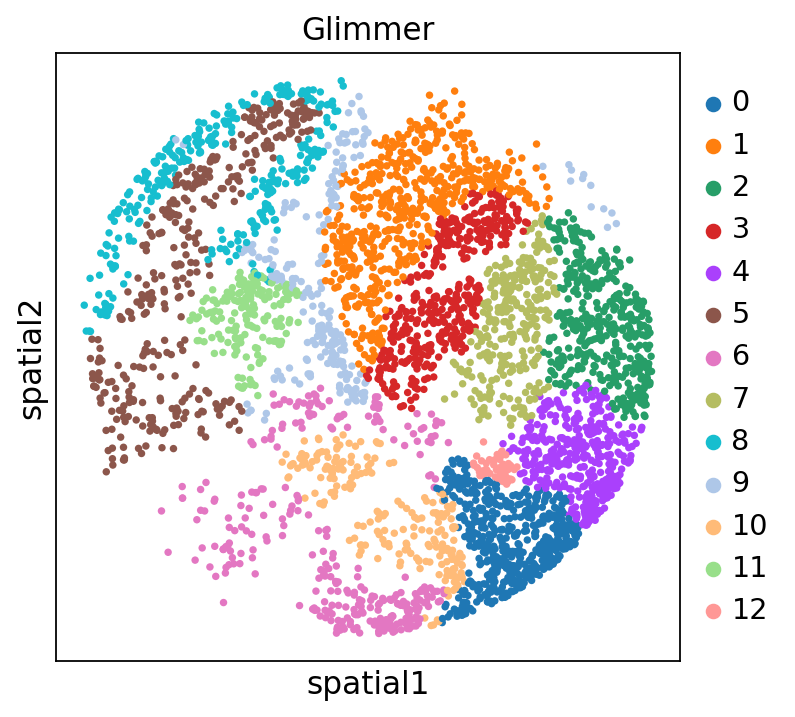

In [10]:
sc.pp.neighbors(adata, use_rep='X_emb_smooth', random_state=seed)
sc.tl.umap(adata) 
sc.tl.leiden(adata, resolution=0.2, random_state=seed)
adata = spatial_smooth(adata, label_key='leiden')
sc.pl.embedding(adata, basis='spatial', color='region', title='Glimmer', s=pt_size) 
if save_fig:
    sc.pl.embedding(adata, basis='spatial', color='region', title='Glimmer', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_glimmer.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## GraphST

In [7]:
from GraphST import GraphST
set_seed(seed)

adata_GraphST = sc.read_h5ad(adata_path)  
model = GraphST.GraphST(adata_GraphST, datatype=['10X', 'Slide'][1], device=device, random_seed=seed)
adata_GraphST = model.train()

Graph constructed!


Building sparse matrix ...
Begin to train ST data.cdnwncowinco..


100%|██████████| 600/600 [00:11<00:00, 54.33it/s]


Optimization finished for ST data!


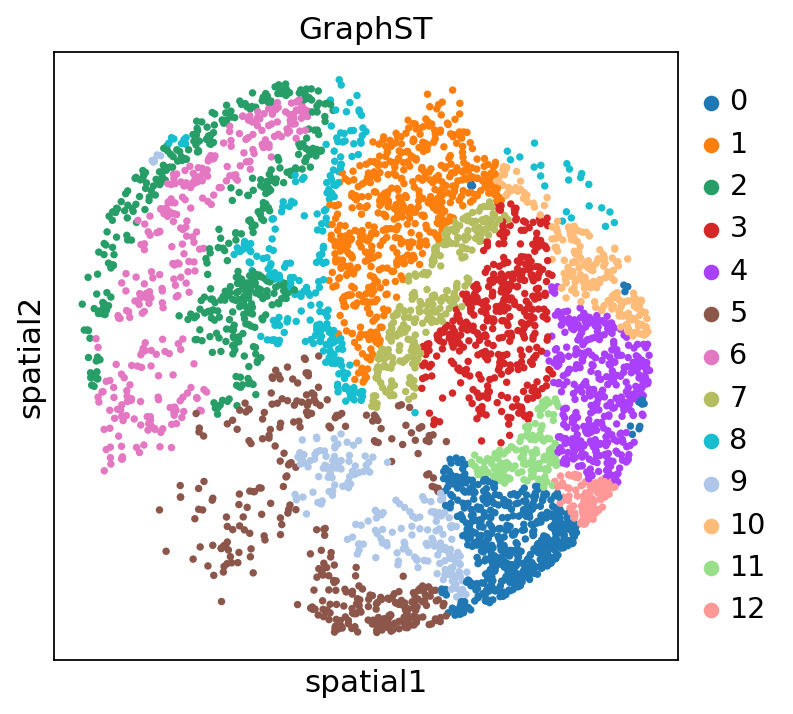

In [8]:
sc.pp.neighbors(adata_GraphST, use_rep='emb', random_state=seed)
sc.tl.leiden(adata_GraphST, resolution=0.18, random_state=seed)
sc.pl.embedding(adata_GraphST, basis='spatial', color='leiden', title='GraphST', s=pt_size) 
if save_fig:
    sc.pl.embedding(adata_GraphST, basis='spatial', color='leiden', title='GraphST', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_graphst.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## SPIN

2025-05-01 16:48:58,757 - SPIN - INFO - Smoothing
2025-05-01 16:49:01,189 - SPIN - INFO - Performing PCA
2025-05-01 16:49:05,066 - SPIN - INFO - Finding latent neighbors
2025-05-01 16:49:05,107 - SPIN - INFO - Performing UMAP
2025-05-01 16:49:09,124 - SPIN - INFO - Leiden clustering
2025-05-01 16:49:09,657 - SPIN - INFO - Clustering complete


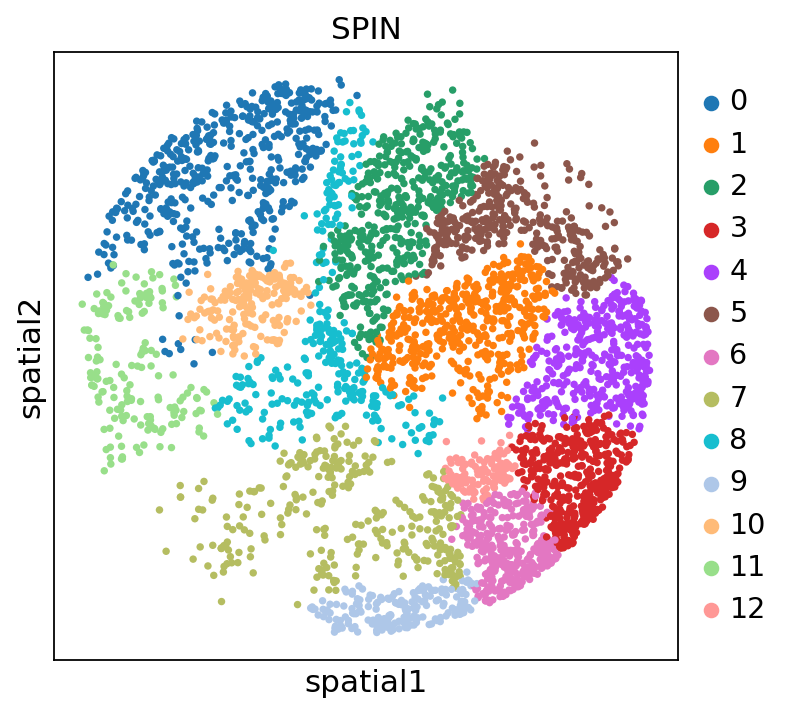

In [9]:
from spin import spin
set_seed(seed)

adata_SPIN = sc.read_h5ad(adata_path)  
adata_SPIN = spin(adata_SPIN, resolution=0.2, random_state=seed) 
sc.pl.embedding(adata_SPIN, basis='spatial', color='region', title='SPIN', s=pt_size, cmap='tab20') 
if save_fig:
    sc.pl.embedding(adata_SPIN, basis='spatial', color='region', title='SPIN', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_spin.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## SpaceFlow

In [10]:
from SpaceFlow import SpaceFlow 
set_seed(seed)

adata_SpaceFlow = sc.read_h5ad(adata_path)  
adata_SpaceFlow.raw = adata_SpaceFlow.copy()
sc.pp.highly_variable_genes(adata_SpaceFlow, n_top_genes=3000, flavor='seurat', subset=True)
sf = SpaceFlow.SpaceFlow(adata=adata_SpaceFlow)
sf.preprocessing_data(n_top_genes=adata_SpaceFlow.shape[1])
sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, 
    lr=1e-3, 
    epochs=1000, 
    max_patience=50, 
    min_stop=100, 
    random_seed=seed, 
    gpu=1, 
    regularization_acceleration=True, 
    edge_subset_sz=1000000
)

Epoch 2/1000, Loss: 3.1365864276885986
Epoch 12/1000, Loss: 1.4006731510162354
Epoch 22/1000, Loss: 1.1459070444107056
Epoch 32/1000, Loss: 0.6800575852394104
Epoch 42/1000, Loss: 0.4541357457637787
Epoch 52/1000, Loss: 0.3465486168861389
Epoch 62/1000, Loss: 0.2630208134651184
Epoch 72/1000, Loss: 0.2217019498348236
Epoch 82/1000, Loss: 0.2526513934135437
Epoch 92/1000, Loss: 0.20096878707408905
Epoch 102/1000, Loss: 0.18402118980884552
Epoch 112/1000, Loss: 0.1733207106590271
Epoch 122/1000, Loss: 0.1485692709684372
Epoch 132/1000, Loss: 0.15269246697425842
Epoch 142/1000, Loss: 0.16265545785427094
Epoch 152/1000, Loss: 0.1733657866716385
Epoch 162/1000, Loss: 0.12068066745996475
Epoch 172/1000, Loss: 0.12191933393478394
Epoch 182/1000, Loss: 0.1292140781879425
Epoch 192/1000, Loss: 0.12537021934986115
Epoch 202/1000, Loss: 0.10516563057899475
Epoch 212/1000, Loss: 0.1070588231086731
Epoch 222/1000, Loss: 0.13934092223644257
Epoch 232/1000, Loss: 0.0977678969502449
Epoch 242/1000, Lo

array([[ 2.149465  , -1.0056983 ,  4.5266266 , ...,  5.67598   ,
        -1.1837322 , -0.06439181],
       [-0.76370984, -0.6898362 , -0.3058942 , ...,  4.652719  ,
        -0.7591929 ,  1.3044564 ],
       [-0.20946363, -0.84736925, -0.24242751, ...,  3.7446487 ,
        -1.4104296 , -0.71921647],
       ...,
       [ 0.64751995, -0.8724081 ,  1.7253324 , ...,  1.554624  ,
        -0.8841949 , -0.48800686],
       [-0.5840298 , -0.7438166 , -0.06157155, ...,  4.60171   ,
        -0.5377933 ,  3.710649  ],
       [-0.40849006, -0.8327057 ,  1.2444203 , ...,  4.04232   ,
        -0.72404563,  2.3976548 ]], dtype=float32)

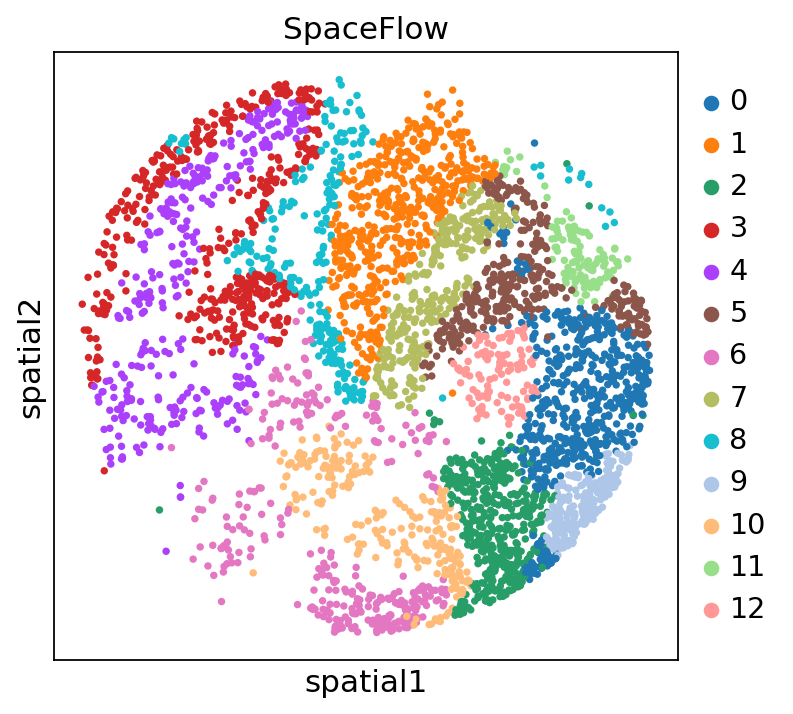

In [11]:
adata_SpaceFlow.obsm['X_spaceflow'] = sf.embedding
sc.pp.neighbors(adata_SpaceFlow, use_rep='X_spaceflow', random_state=seed)
sc.tl.umap(adata_SpaceFlow)
sc.tl.leiden(adata_SpaceFlow, resolution=0.38, random_state=seed)
sc.pl.embedding(adata_SpaceFlow, basis='spatial', color='leiden', title='SpaceFlow', s=pt_size, cmap='tab20') 
if save_fig:
    sc.pl.embedding(adata_SpaceFlow, basis='spatial', color='leiden', title='SpaceFlow', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_spaceflow.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## SCANIT

In [12]:
import scanit 
set_seed(seed)

adata_SCANIT = sc.read_h5ad(adata_path)  
scanit.tl.spatial_graph(
    adata_SCANIT, 
    method='alpha shape', 
    alpha_n_layer=2, 
    knn_n_neighbors=5
)
scanit.tl.spatial_representation(
    adata_SCANIT, 
    n_h=30, 
    n_epoch=2000, 
    lr=0.001, 
    data_slot = ['X_pca', None][0],
    device=device, 
    n_consensus=1, 
    projection='mds', 
    python_seed=seed, 
    torch_seed=seed, 
    numpy_seed=seed
)

Epoch: 000, Loss: 2.2394


Epoch: 500, Loss: 0.0406
Epoch: 1000, Loss: 0.0206
Epoch: 1500, Loss: 0.0138
Epoch: 1999, Loss: 0.0101


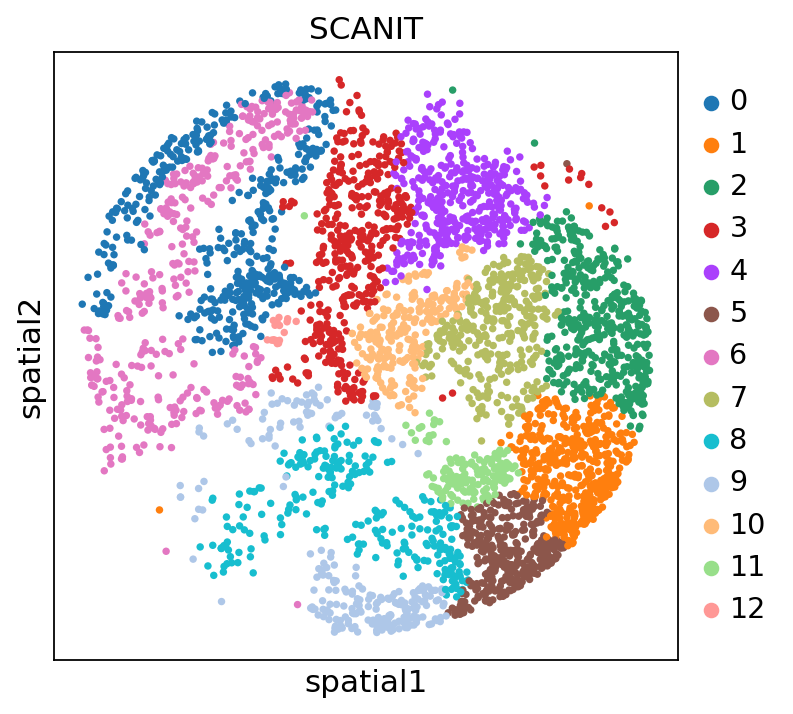

In [13]:
sc.pp.neighbors(adata_SCANIT, use_rep='X_scanit', random_state=seed)
sc.tl.umap(adata_SCANIT)
sc.tl.leiden(adata_SCANIT, resolution=0.21, random_state=seed)
sc.pl.embedding(adata_SCANIT, basis='spatial', color='leiden', title='SCANIT', s=pt_size, cmap='tab20') 
if save_fig:
    sc.pl.embedding(adata_SCANIT, basis='spatial', color='leiden', title='SCANIT', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_scanit.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()

## Banksy

In [14]:
%reload_ext rpy2.ipython

In [15]:
%%R

suppressMessages(library(Banksy))
suppressMessages(library(rhdf5))
suppressMessages(library(scater))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(SpatialExperiment))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(SeuratWrappers))
seed = 42

dir = "/data/qiyu/spatialRegion/data/slidetag/slidetag_mouse_embryonic_E14_brain/"

banksy_emb_file = paste0(dir, "banksy_emb.txt")
if (file.exists(banksy_emb_file)) {
  print("Banksy embedding exists")
} else {
  file_path <- paste0(dir, "RNA_adata_circle.h5ad")
  exprs_data <- as.numeric(h5read(file_path, "X/data"))
  indices <- h5read(file_path, "X/indices")
  indptr <- h5read(file_path, "X/indptr")
  n_cells <- length(indptr) - 1
  n_features <- max(indices) + 1  
  exprs_matrix <- Matrix::sparseMatrix(i=indices + 1, p=indptr, x=exprs_data, dims=c(n_features, n_cells))
  locs <- t(h5read(file_path, "obsm/spatial"))
  obj <- SpatialExperiment(assay=list(counts=exprs_matrix), spatialCoords=locs)
  obj <- computeLibraryFactors(obj)
  assay(obj, "normcounts") <- normalizeCounts(obj, log=FALSE)
  obj <- Banksy::computeBanksy(obj, assay_name="normcounts", compute_agf=TRUE, k_geom=c(15, 30), seed=seed)
  obj <- Banksy::runBanksyPCA(obj, use_agf=TRUE, seed=seed, lambda=0.8)
  banksy_emb <- obj@int_colData@listData$reducedDims$PCA_M1_lam0.8
  write.table(banksy_emb, file=banksy_emb_file, row.names=TRUE, col.names=TRUE)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "Banksy embedding exists"


In addition: Warning message:
package ‘ggplot2’ was built under R version 4.3.3 


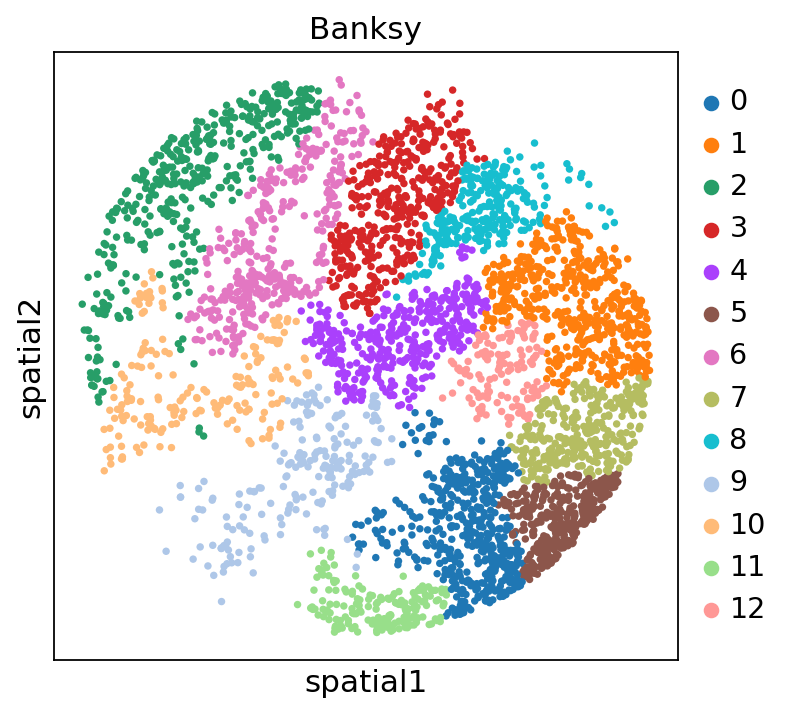

In [16]:
adata_Banksy = sc.read_h5ad(adata_path)  
banksy_emb = pd.read_csv(os.path.join(dir, "banksy_emb.txt"), index_col=0, sep=' ')
adata_Banksy.obsm['X_banksy'] = banksy_emb.values
sc.pp.neighbors(adata_Banksy, use_rep='X_banksy', random_state=seed)
sc.tl.umap(adata_Banksy)
sc.tl.leiden(adata_Banksy, resolution=0.13, random_state=seed)
sc.pl.embedding(adata_Banksy, basis='spatial', color='leiden', title='Banksy', s=pt_size, cmap='tab20') 
if save_fig:
    sc.pl.embedding(adata_Banksy, basis='spatial', color='leiden', title='Banksy', s=pt_size, cmap='tab20', show=False)
    plt.savefig(f"{fig_path}figure3/fig3_m_slidetag_brain_banksy.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.close()